In [85]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [86]:
ticker = 'TCS.NS'
current_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start="2015-01-01", end=current_date)


[*********************100%***********************]  1 of 1 completed


In [87]:
# Moving Averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# RSI
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']

# Bollinger Bands
data['MA20'] = data['Close'].rolling(window=20).mean()
data['20_day_std'] = data['Close'].rolling(window=20).std()
data['Upper_BB'] = data['MA20'] + (2 * data['20_day_std'])
data['Lower_BB'] = data['MA20'] - (2 * data['20_day_std'])

# Filling NaN values if necessary
data.fillna(method='bfill', inplace=True)
data

C:\Users\naveen kumar pandey\AppData\Local\Temp\ipykernel_27012\3546357861.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


Price,Adj Close,Close,High,Low,Open,Volume,MA50,MA200,RSI,EMA12,EMA26,MACD,MA20,20_day_std,Upper_BB,Lower_BB
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,1051.877319,1272.775024,1283.500000,1270.500000,1283.500000,366830,1283.439998,1281.914499,44.135235,1272.775024,1272.775024,0.000000,1255.378754,19.140816,1293.660386,1217.097121
2015-01-02 00:00:00+00:00,1065.885986,1289.724976,1295.474976,1275.300049,1275.500000,925740,1283.439998,1281.914499,44.135235,1275.382709,1274.030576,1.352133,1255.378754,19.140816,1293.660386,1217.097121
2015-01-05 00:00:00+00:00,1049.687256,1270.125000,1299.949951,1262.324951,1290.500000,1754242,1283.439998,1281.914499,44.135235,1274.573831,1273.741274,0.832556,1255.378754,19.140816,1293.660386,1217.097121
2015-01-06 00:00:00+00:00,1010.989380,1223.300049,1264.550049,1220.000000,1264.550049,2423784,1283.439998,1281.914499,44.135235,1266.685557,1270.004887,-3.319331,1255.378754,19.140816,1293.660386,1217.097121
2015-01-07 00:00:00+00:00,999.047058,1208.849976,1239.574951,1203.724976,1235.000000,2636332,1283.439998,1281.914499,44.135235,1257.787775,1265.474894,-7.687119,1255.378754,19.140816,1293.660386,1217.097121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28 00:00:00+00:00,4090.850098,4090.850098,4134.000000,4051.000000,4068.949951,1532534,4330.430986,4068.620251,30.000012,4104.296340,4177.619850,-73.323510,4156.769995,89.148366,4335.066727,3978.473263
2024-10-29 00:00:00+00:00,4075.250000,4075.250000,4103.500000,4060.100098,4095.850098,1445885,4322.135986,4070.662501,28.910507,4099.827672,4170.036898,-70.209226,4147.107495,86.844031,4320.795558,3973.419432


In [88]:
nifty_data = yf.download('^NSEI', start="2015-01-01", end=current_date)['Close']
data['NIFTY_50'] = nifty_data

[*********************100%***********************]  1 of 1 completed


In [89]:
usd_inr_data = yf.download('USDINR=X', start="2015-01-01", end=current_date)['Close']
data['USD_INR'] = usd_inr_data

[*********************100%***********************]  1 of 1 completed


In [111]:
data.fillna(data.mean(), inplace=True)

data

Price,Adj Close,Close,High,Low,Open,Volume,MA50,MA200,RSI,EMA12,EMA26,MACD,MA20,20_day_std,Upper_BB,Lower_BB,NIFTY_50,USD_INR
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,1051.877319,1272.775024,1283.500000,1270.500000,1283.500000,366830,1283.439998,1281.914499,44.135235,1272.775024,1272.775024,0.000000,1255.378754,19.140816,1293.660386,1217.097121,13335.955085,63.028000
2015-01-02 00:00:00+00:00,1065.885986,1289.724976,1295.474976,1275.300049,1275.500000,925740,1283.439998,1281.914499,44.135235,1275.382709,1274.030576,1.352133,1255.378754,19.140816,1293.660386,1217.097121,8395.450195,63.028000
2015-01-05 00:00:00+00:00,1049.687256,1270.125000,1299.949951,1262.324951,1290.500000,1754242,1283.439998,1281.914499,44.135235,1274.573831,1273.741274,0.832556,1255.378754,19.140816,1293.660386,1217.097121,8378.400391,63.278000
2015-01-06 00:00:00+00:00,1010.989380,1223.300049,1264.550049,1220.000000,1264.550049,2423784,1283.439998,1281.914499,44.135235,1266.685557,1270.004887,-3.319331,1255.378754,19.140816,1293.660386,1217.097121,8127.350098,63.338001
2015-01-07 00:00:00+00:00,999.047058,1208.849976,1239.574951,1203.724976,1235.000000,2636332,1283.439998,1281.914499,44.135235,1257.787775,1265.474894,-7.687119,1255.378754,19.140816,1293.660386,1217.097121,8102.100098,63.568001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28 00:00:00+00:00,4090.850098,4090.850098,4134.000000,4051.000000,4068.949951,1532534,4330.430986,4068.620251,30.000012,4104.296340,4177.619850,-73.323510,4156.769995,89.148366,4335.066727,3978.473263,24339.150391,84.101997
2024-10-29 00:00:00+00:00,4075.250000,4075.250000,4103.500000,4060.100098,4095.850098,1445885,4322.135986,4070.662501,28.910507,4099.827672,4170.036898,-70.209226,4147.107495,86.844031,4320.795558,3973.419432,24466.849609,84.102798


In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2428 entries, 2015-01-01 00:00:00+00:00 to 2024-11-01 00:00:00+00:00
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, TCS.NS)  2428 non-null   float64
 1   (Close, TCS.NS)      2428 non-null   float64
 2   (High, TCS.NS)       2428 non-null   float64
 3   (Low, TCS.NS)        2428 non-null   float64
 4   (Open, TCS.NS)       2428 non-null   float64
 5   (Volume, TCS.NS)     2428 non-null   int64  
 6   (MA50, )             2428 non-null   float64
 7   (MA200, )            2428 non-null   float64
 8   (RSI, )              2428 non-null   float64
 9   (EMA12, )            2428 non-null   float64
 10  (EMA26, )            2428 non-null   float64
 11  (MACD, )             2428 non-null   float64
 12  (MA20, )             2428 non-null   float64
 13  (20_day_std, )       2428 non-null   float64
 14  (Upper_BB, )         2428 non-null   flo

In [185]:
# Normalize the features
feature_columns = ['Close', 'MA50', 'MA200', 'RSI','EMA12','EMA26', 'MACD','MA20', '20_day_std','Upper_BB', 'Lower_BB','Volume']
target_column = 'Close'

In [186]:
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(data[feature_columns])
scaled_target = scaler_target.fit_transform(data[[target_column]])

In [187]:
# Create sequences (e.g., 60 days to predict the next day)
def create_sequences(data, target, step_size):
    X, y = [], []
    for i in range(len(data) - step_size):
        X.append(data[i:(i + step_size), :])  # Sequence of step_size days
        y.append(target[i + step_size])  # Next day’s target
    return np.array(X), np.array(y)

In [188]:
# Set step size (e.g., using past 60 days)
step_size = 60
X, y = create_sequences(scaled_features, scaled_target, step_size)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [189]:
# LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predict next day's closing price


C:\Users\naveen kumar pandey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [190]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [191]:
# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')

In [192]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
          callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.0288 - val_loss: 0.0032
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0023 - val_loss: 9.7927e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0015 - val_loss: 8.0019e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0017 - val_loss: 9.4196e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0016 - val_loss: 8.8654e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0019 - val_loss: 9.1359e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0014 - val_loss: 7.8522e-04
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━

In [193]:
# Make predictions
predictions = model.predict(X_test)
predicted_prices = scaler_target.inverse_transform(predictions)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


In [198]:
comparison_df = pd.DataFrame({
    'Actual Price': actual_prices.flatten(),    # Flatten to convert from 2D to 1D
    'Predicted Price': predicted_prices.flatten()})

comparison_df.to_csv('TCS_Prediction.csv', index=False)

In [199]:
import pandas_profiling as pp
pp.ProfileReport(comparison_df)

C:\Users\naveen kumar pandey\AppData\Local\Temp\ipykernel_27012\3151836217.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [195]:
# Evaluate the model
actual_prices = scaler_target.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 8574.262789996747
Mean Absolute Error: 69.99862838294439
R² Score: 0.9429425498620007


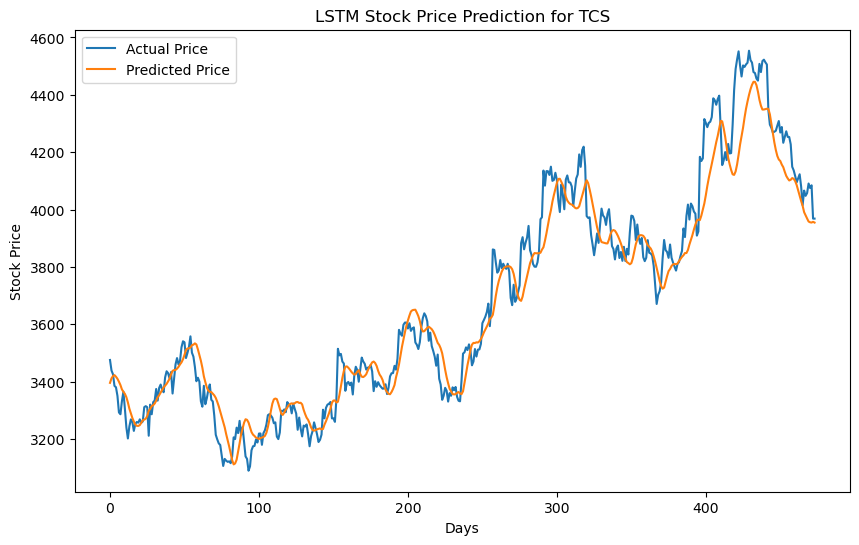

In [196]:
# Plot actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("LSTM Stock Price Prediction for TCS")
plt.legend()
plt.show()